In [1]:
import json
from PIL import Image
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

# This script fine-tunes a CLIP model on a custom dataset of images and their corresponding titles.
data_train = pd.read_csv('./dataset/alpaca_mbj_bandgap_train.csv') # Load your training data if needed


# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


# Choose computation device
device = "cuda:1" if torch.cuda.is_available() else "cpu" 

# Load pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)


/home/jipengsun/.conda/envs/clipp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
# From list to image shape img to image
import numpy as np
def list_to_image(img_list, size=128):
    """
    Convert a list to a 2D image of given size.
    """
    return np.array(json.loads(img_list)).reshape(size, size)

from torchvision import transforms
from PIL import Image

torch_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to expected size
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4815, 0.4578, 0.4082], std=[0.2686, 0.2613, 0.2758]),
])

In [3]:

# Define a custom dataset
class image_title_dataset():
    def __init__(self, dataframe):
        # Tokenize text
        self.text  = clip.tokenize(dataframe["input"])
        self.dataframe = dataframe

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = list_to_image(self.dataframe["image"][idx])
        image = Image.fromarray(image)
        image = preprocess(image)
        title = self.text[idx]
        return image, title

dataset = image_title_dataset(data_train)

Epoch 1/2, Loss: 3.1602: 100%|██████████| 140/140 [05:59<00:00,  2.57s/it]


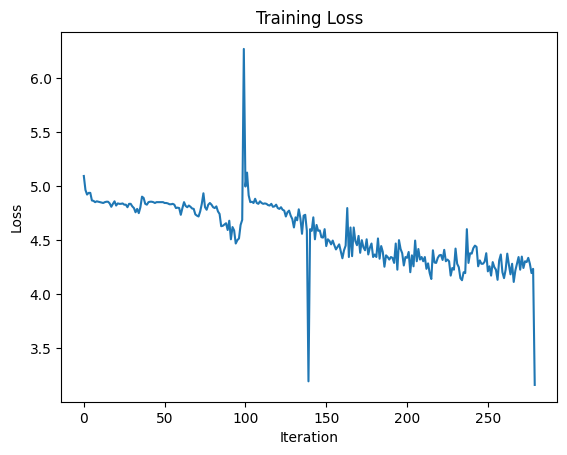

In [4]:

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True) #Define your own dataloader

import matplotlib.pyplot as plt
# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == "cpu":
  model.float()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset

loss_history = []


# Specify the loss function
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# Train the model
num_epochs = 2
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images,texts = batch 
        
        images= images.to(device)
        texts = texts.to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

        # Backward pass
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        loss_history.append(total_loss.item())

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [6]:
# save the fine-tuned model
torch.save(model, "./model/clip_finetuned.pt")
# save the processor
torch.save(processor, "./model/fine_tuned_clip_processor.pt")